In [80]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import seaborn as sns
import plotnine as p9
from mpl_toolkits.mplot3d import Axes3D
from pylab import *
from sklearn.manifold import TSNE
from palettable.colorbrewer.sequential import *
from pathlib import Path
import umap.umap_ as umap
from scipy import stats
from scipy.stats import ttest_ind


In [36]:
top_dir = os.path.dirname(os.getcwd())
outpath = os.path.join(top_dir, "Figures_new")
outpath

'/Users/habbasi/Documents/Github/broadinstitute/050919_Nathianel_Gray/Figures_new'

## Data Paths

In [4]:
path = Path("../collated/")
#outpath = Path("/Welch_ttest/")
fname = "C-7210-01-CMP-008-gray_collapsed_sampled.csv"
fpath = os.path.join(path, fname)
df = pd.read_csv(fpath)


metadata = [col for col in df.columns if "Metadata" in col]
var = [col for col in df.columns if not "Metadata" in col]
exclude_var = ['Cells_Correlation_Costes_DNA_Mito',
 'Cytoplasm_Correlation_Costes_DNA_Mito',
 'Cytoplasm_Correlation_Costes_DNA_RNA']

variables = [v for v in var if v not in exclude_var]
len(variables)

595

## Welch Ttest

In [5]:
df['Metadata_Target'].replace(np.nan, 'NA', inplace=True)
df['Metadata_Annotation'].replace('active ', 'active', inplace=True)

p = ['NA', 'SECRET']

excluded = ["C1", "C2", "C3", "C4"]

tt = []

for c in df.Metadata_cell_line.unique():
    d = df.query('Metadata_cell_line in @ c and Metadata_compound_name not in @ excluded and Metadata_Target in @p')

    for i in variables:
        test = d.Metadata_compound_name.unique().tolist()
        gp1 = d.query("Metadata_compound_name in @ test[0]")[i].values
        gp2 = d.query("Metadata_compound_name in @ test[1]")[i].values
        gp3 = d.query("Metadata_compound_name in @ test[2]")[i].values
    

        t1 = ttest_ind(gp1, gp2, equal_var=False)
        t2 = ttest_ind(gp1, gp3, equal_var=False)
        t3 = ttest_ind(gp2, gp3, equal_var=False)



        d1 = {"Paired": [test[0]+', '+ test[1], test[0]+', '+ test[2], test[1]+', '+ test[2]],
          "Statistics": [t1[0], t2[0], t3[0]],
          "P-value": [t1[1], t2[1], t3[1]],
          "Variables": str(i),
          "Cellline": str(c)}



        prf = pd.DataFrame(d1, columns = ['Paired','Statistics', 'P-value', 'Variables', "Cellline"])
    
        tt.append(prf)
final_tt = pd.concat(tt)

    
final_tt['logp'] = -log10(final_tt['P-value'])
index = [i for i in range(1, len(final_tt) +1)]
final_tt['index'] =  index
 
    


/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/habbasi/Documents/Github/broadinstitute/050919_Nathianel_Gray/Figures_new/Welch_test_SECRET_95percentile_A549.png


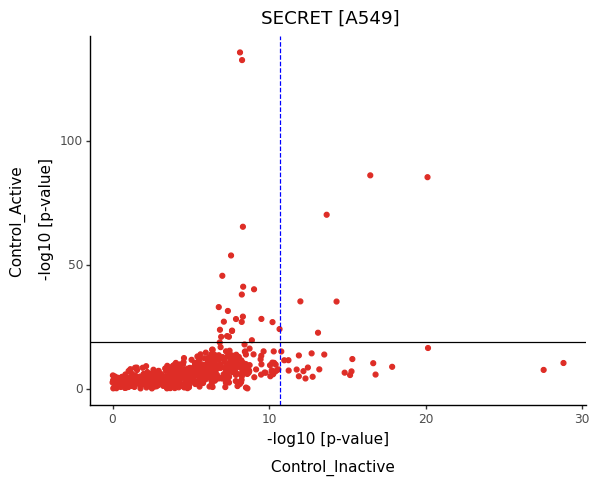

<ggplot: (7042433357)>

In [180]:
d1 = (final_tt.query("Paired == 'DMSO, BSJ-04-030'")
      .rename(columns={"logp": "Control_Inactive"})
      .reset_index()
      .drop(columns=["level_0", "index"])
     )
d2 = (final_tt.query("Paired == 'DMSO, BSJ-03-136'")
      .rename(columns = {"logp": "Control_Active"})
      .reset_index()
      .drop(columns=["level_0", "index", "Cellline", "Variables"])
)

result = pd.concat([d1, d2], axis=1)

col_var = ["Control_Inactive", "Control_Active", "Variables", "Cellline"]

prf = result.loc[:, col_var]

c = "A549"

pf = prf.query("Cellline in @ c")



control_active = pf.Control_Active.quantile(0.95)
control_inactive = pf.Control_Inactive.quantile(0.95)


g = (ggplot(pf, gg.aes(x='Control_Inactive', y='Control_Active'))
     + geom_point(size = 1.5, color="#de2d26")
     + geom_vline(xintercept= control_inactive, color="blue",linetype='dashed')
     + theme_classic() 
     + geom_hline(aes(yintercept = control_active), colour = 'black')
     + labs(title='SECRET ' + "[" + str(c) + "]" , x="-log10 [p-value] \n\n Control_Inactive", y="Control_Active \n\n -log10 [p-value] ")

    )
  
 
ggsave(filename='Welch_test_SECRET_95percentile_' + str(c) + ".png", plot = g, path = outpath)


g


In [181]:

d3 = (final_tt.query("Paired == 'BSJ-04-030, BSJ-03-136' and logp > @ control_inactive and Cellline in @ c")
      .sort_values(by='logp', ascending=False)
     )

d3_var = d3.Variables.tolist()
d3_var


['Cytoplasm_Texture_DifferenceEntropy_ER_20_0',
 'Cells_RadialDistribution_RadialCV_RNA_3of4',
 'Cells_RadialDistribution_RadialCV_RNA_4of4',
 'Cytoplasm_Intensity_MassDisplacement_RNA']

In [182]:
p = ['NA', 'SECRET']

excluded = ["C1", "C2", "C3", "C4"]


d = df.query('Metadata_cell_line in @ c and Metadata_compound_name not in @ excluded and Metadata_Target in @p')


for i, var in enumerate(d3_var):
    g = (ggplot()
    #+ geom_histogram(aes(x=str(var), y='stat(density)', color = 'Metadata_compound_name', fill= 'Metadata_compound_name'), data=d, alpha=.2)
    + geom_density(aes(x=str(var), y='stat(density)', color = 'Metadata_compound_name', fill= 'Metadata_compound_name'), data= d, alpha=.1)
    + xlab(str(var))
    + ylab("Density") 
    + labs(title='Density plot')
#     + scale_colour_manual(name= "Platemap", labels=['DMSO', 'BSJ-03-136', 'BSJ-04-030'], 
#                            values = ["#d95f0e", "#fec44f", "#2c7fb8"])
    
    )

    g = g + theme_classic()


    ggsave(filename= str(var)+ ".png", plot = g, path = os.path.join(outpath, "Densityplot", c))




/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/habbasi/Documents/Github/broadinstitute/050919_Nathianel_Gray/Figures_new/Densityplot/A549/Cytoplasm_Texture_DifferenceEntropy_ER_20_0.png
/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/habbasi/Documents/Github/broadinstitute/050919_Nathianel_Gray/Figures_new/Densityplot/A549/Cells_RadialDistribution_RadialCV_RNA_3of4.png
/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/habbasi/Documents/Github/broadinstitute/050919_Nathianel_Gray/Figures_new/Densityplot/A549/Cells_RadialDistribution_RadialCV_RNA_4of4.png
/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning

In [187]:
#tmp = d.query("Metadata_cell_line == 'A549'")
d.Metadata_cell_line.unique()

array(['A549', 'U2OS'], dtype=object)

In [184]:
from sklearn.decomposition import PCA


In [197]:
p = ['SECRET']

excluded = ["C1", "C2", "C3", "C4", "DMSO"]


c = "A549"


d = df.query('Metadata_compound_name not in @ excluded and Metadata_Target in @p and Metadata_cell_line in @ c')

d.Metadata_cell_line.unique()

array(['A549'], dtype=object)

In [198]:
pc_meta = d.loc[:, metadata].reset_index()
pc_var = d.loc[:, variables].values

model = PCA(n_components=2)
pca = model.fit_transform(pc_var)

PC1 = round(model.explained_variance_ratio_[0], 3) * 100
PC2 = round(model.explained_variance_ratio_[1], 3) * 100

test = pd.DataFrame(pca, columns= ['PC1', 'PC2'])

# Setup plotting logic
combined = test.merge(pc_meta, left_index=True, right_index=True)
combined.head()


# g = (ggplot(combined, gg.aes(x='PC1', y='PC2', color="Metadata_compound_name", shape='Metadata_cell_line')) 
#      + geom_point(size = 1.5)
#      + scale_colour_manual(name= 'Compound_name', values=["#de2d26", "#984ea3", "#01665e"])
#      + scale_shape_manual(name="Celllines", labels=['A549', 'U2oS'], values=['*', 'o'])
#      + theme_classic()
#      + labs(title='SECRET', x="PC1 "+ str([PC1])+"%", y="PC2 "+ str([PC2])+"%")
    

#     )

# ggsave(filename='SECRET_PCA.pdf', plot = g, path = outpath)
# g


,PC1,PC2,index,Metadata_Plate,Metadata_Well,Metadata_broad_sample,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_cell_line,Metadata_well_position,...,Metadata_pert_id_vendor,Metadata_broad_sample_type,Metadata_pert_vehicle,Metadata_pert_type,Metadata_label,Metadata_chemist,Metadata_compound_name,Metadata_Annotation,Metadata_Target,Metadata_Broad_barcode
0,-67.486211,0.384005,148,BR00100032,G05,BRD-U68785813-000-01-5,BR00100032,C-7210-01-CMP-008-gray,A549,G05,...,NaN,trt,DMSO,trt,6,Baishan Jiang,BSJ-04-030,inactive (protac),SECRET,1.136944e+09
1,-68.797090,7.458148,152,BR00100032,G09,BRD-U68785813-000-01-5,BR00100032,C-7210-01-CMP-008-gray,A549,G09,...,NaN,trt,DMSO,trt,6,Baishan Jiang,BSJ-04-030,inactive (protac),SECRET,1.136944e+09
2,-60.057484,18.089509,161,BR00100032,G18,BRD-U68785813-000-01-5,BR00100032,C-7210-01-CMP-008-gray,A549,G18,...,NaN,trt,DMSO,trt,6,Baishan Jiang,BSJ-04-030,inactive (protac),SECRET,1.136944e+09
3,-35.978915,23.952113,165,BR00100032,G22,BRD-U68785813-000-01-5,BR00100032,C-7210-01-CMP-008-gray,A549,G22,...,NaN,trt,DMSO,trt,6,Baishan Jiang,BSJ-04-030,inactive (protac),SECRET,1.136944e+09
4,61.290721,-13.297887,172,BR00100032,H05,BRD-U43181200-000-01-8,BR00100032,C-7210-01-CMP-008-gray,A549,H05,...,NaN,trt,DMSO,trt,5,Baishan Jiang,BSJ-03-136,active (protac),SECRET,1.136944e+09


In [199]:
n_pcs= model.components_.shape[0]


initial_feature_names = variables

# get the index of the most important feature on EACH component i.e. largest absolute value


most_important = [np.abs(model.components_[i]).argsort()[-11:][::-1] for i in range(n_pcs)]
most_important[0]

pc1 = []

for i, p in enumerate(initial_feature_names):
    
    for pc in most_important[0]:
        
        if i == pc:
            
            pc1.append(p)
            

pc2=[]            
for i, p in enumerate(initial_feature_names):
    
    for pc in most_important[1]:
        
        if i == pc:
            
            pc2.append(p)
pc2

    
dic1 = {'PC1': pc1}
dic2= {'PC2': pc2}
print(dic1)
#print(dic2)



# # using LIST COMPREHENSION HERE AGAIN
# dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}




{'PC1': ['Cells_Intensity_MassDisplacement_ER', 'Cells_Intensity_MassDisplacement_Mito', 'Cells_RadialDistribution_RadialCV_ER_4of4', 'Cells_RadialDistribution_RadialCV_Mito_4of4', 'Cells_RadialDistribution_RadialCV_RNA_3of4', 'Cells_Texture_InfoMeas1_Mito_20_0', 'Cytoplasm_Intensity_MassDisplacement_AGP', 'Cytoplasm_Texture_SumEntropy_ER_20_0', 'Nuclei_Granularity_13_AGP', 'Nuclei_Intensity_MassDisplacement_DNA', 'Nuclei_RadialDistribution_RadialCV_ER_2of4']}


In [150]:
print(dic2)

{'PC2': ['Cells_AreaShape_Compactness', 'Cells_AreaShape_Extent', 'Nuclei_AreaShape_Compactness', 'Nuclei_AreaShape_FormFactor', 'Nuclei_AreaShape_Zernike_0_0', 'Nuclei_AreaShape_Zernike_4_0', 'Nuclei_AreaShape_Zernike_4_4', 'Nuclei_AreaShape_Zernike_6_6', 'Nuclei_AreaShape_Zernike_8_8', 'Nuclei_Intensity_MassDisplacement_DNA', 'Nuclei_RadialDistribution_FracAtD_Mito_1of4']}


In [ ]:
x = 11.72866053483449/log10()

In [ ]:
import numpy as np
for i in finalvalues.values():
    print np.percentile(map(int,i),95)

## Welch ttest for ERK5

In [ ]:
tt = []

for i in variables:
    test = d.Metadata_compound_name.unique().tolist()
    gp0 = d.query("Metadata_compound_name in @ test[0]")[i].values
    gp1 = d.query("Metadata_compound_name in @ test[1]")[i].values
    gp2 = d.query("Metadata_compound_name in @ test[2]")[i].values
    gp3 = d.query("Metadata_compound_name in @ test[3]")[i].values
    

    t0 = ttest_ind(gp0, gp1, equal_var=False)
    t1 = ttest_ind(gp0, gp2, equal_var=False)
    t2 = ttest_ind(gp0, gp3, equal_var=False)
    t3 = ttest_ind(gp1, gp2, equal_var=False)
    t4 = ttest_ind(gp1, gp3, equal_var=False)
    t5 = ttest_ind(gp2, gp3, equal_var=False)



    d1 = {"Paired": [test[0]+', '+ test[1], test[0]+', '+ test[2], test[0]+', '+ test[3], test[1]+', '+ test[2], test[1]+', '+ test[3], test[2]+', '+ test[3]],
      "Statistics": [t0[0], t1[0], t2[0], t3[0], t4[0], t5[0]],
      "P-value": [t0[1], t1[1], t2[1], t3[1], t4[1], t5[1]],
      "Variables": str(i)}



    prf = pd.DataFrame(d1, columns = ['Paired','Statistics', 'P-value', 'Variables'])
    
    tt.append(prf)
final_tt = pd.concat(tt)
    
final_tt['logp'] = -log10(final_tt['P-value'])
index = [i for i in range(1, len(final_tt) +1)]
final_tt['index'] =  index
final_tt.head()   

In [ ]:
final_tt.to_csv("ERK5_ttest_U2OS.csv",index=False)

### Welch ttest

In [ ]:
tt = []

for i in variables:
    test = d.Metadata_compound_name.unique().tolist()
    gp1 = d.query("Metadata_compound_name in @ test[0]")[i].values
    gp2 = d.query("Metadata_compound_name in @ test[1]")[i].values
    gp3 = d.query("Metadata_compound_name in @ test[2]")[i].values
    

    t1 = ttest_ind(gp1, gp2, equal_var=False)
    t2 = ttest_ind(gp1, gp3, equal_var=False)
    t3 = ttest_ind(gp2, gp3, equal_var=False)



    d1 = {"Paired": [test[0]+', '+ test[1], test[0]+', '+ test[2], test[1]+', '+ test[2]],
      "Statistics": [t1[0], t2[0], t3[0]],
      "P-value": [t1[1], t2[1], t3[1]],
      "Variables": str(i)}



    prf = pd.DataFrame(d1, columns = ['Paired','Statistics', 'P-value', 'Variables'])
    
    tt.append(prf)
final_tt = pd.concat(tt)
    
final_tt['logp'] = -log10(final_tt['P-value'])
index = [i for i in range(1, len(final_tt) +1)]
final_tt['index'] =  index
final_tt.head()  

In [ ]:
final_tt.to_csv("PIN1_ttest_U2oS.csv",index=False)

# kruskal Wallis test

In [ ]:


p = ['NA', 'DCLK1']

tmp = d.query("Metadata_Target in @p")




kw = []

for i in variables:
    test = tmp.Metadata_compound_name.unique().tolist()
    gp1 = tmp.query("Metadata_compound_name in @ test[0]")[i].tolist()
    gp2 = tmp.query("Metadata_compound_name in @ test[1]")[i].tolist()
    gp3 = tmp.query("Metadata_compound_name in @ test[2]")[i].tolist()
    

    k1 = stats.kruskal(gp1, gp2)
    k2 = stats.kruskal(gp1, gp3)
    k3 = stats.kruskal(gp2, gp3)



    d1 = {"Paired": [test[0]+', '+ test[1], test[0]+', '+ test[2], test[1]+', '+ test[2]],
      "Statistics": [k1[0], k2[0], k3[0]],
      "P-value": [k1[1], k2[1], k3[1]],
      "Variables": str(i)}



    prf = pd.DataFrame(d1, columns = ['Paired','Statistics', 'P-value', 'Variables'])
    
    kw.append(prf)
final_kw = pd.concat(kw)
    
final_kw['logp'] = -log10(final_kw['P-value'])
index = [i for i in range(1, len(final_kw) +1)]
final_kw['index'] =  index
final_kw.head()   

In [ ]:
final_kw.head()

In [ ]:
final_kw.to_csv("DCLK_kw_U2oS.csv", index=False)

In [ ]:
# tt = []
# for v in final_kw.Variables.unique():
    
#     tv = final_kw.query('Variables in @ v')
    
#     if (tv.iloc[0]["P-value"] < 0.05) & (tv.iloc[1]["P-value"] < 0.05) & (tv.iloc[2]["P-value"] < 0.05):
        
#         tt.append(tv)
    
# tmp2 = pd.concat(tt)




In [ ]:
topdifvar = (final_kw
.sort_values(by="logp", ascending=False)
.groupby("Paired")
.head(10)
)
 
finallist = topdifvar[~topdifvar['Paired'].str.contains("DMSO")]['Variables'].tolist() 
finallist

#geom_hline(aes(yintercept = med, group = gr), colour = 'red')

In [ ]:
g = (ggplot(final_kw, gg.aes(x='index', y='logp', color= "Paired")) 
     + geom_point(size = 1.5) 
     + facet_wrap('~Paired')
     + theme_bw() 
     + geom_hline(aes(yintercept = med, group = gr), colour = 'red')
     #+ geom_text(aes(label="Variables"), data=best_in_class) 
     + labs(title='Drugs targetting DCLK1', x="Variables ID", y="-log10 [p-value] "))
  
 
g

In [ ]:
+
  geom_text(aes(label=ifelse(PTS>24,as.character(Name),'')),hjust=0,vjust=0)

In [ ]:

ggplot(mpg, aes("displ", "hwy")) +\
geom_point(aes(colour="class")) +\
geom_text(aes(label="model"), data=best_in_class)

In [ ]:
#final_kw.loc[(final_kw['P-value'] < 0.05) & (final_kw['Paired'] < 0.05)]


In [ ]:
ttt.head()




In [ ]:
def log_p(d):
    d['P-value'] = -log10(d['P-value'])
    return d

tp = log_p(ttt)
tp.head()

ttt

In [ ]:


gp1 =df.query("Metadata_cell_line == 'U2OS' and Metadata_compound_name == 'FMF-04-159-2'")['Cells_AreaShape_Area'].tolist()
gp2 =df.query("Metadata_cell_line == 'U2OS' and Metadata_compound_name == 'FMF-05-176-1'")['Cells_AreaShape_Area'].tolist()
gp3 =df.query("Metadata_cell_line == 'U2OS' and Metadata_compound_name == 'DMSO'")['Cells_AreaShape_Area'].tolist()


from scipy import stats


stats.kruskal(gp1, gp2)


In [ ]:
np.random.seed(123)
reducer=umap.UMAP()
embedding = reducer.fit_transform(df.loc[:, variables].values)


test = pd.DataFrame(embedding, columns= ['UMAP-1', 'UMAP-2'])
combined = test.merge(df.loc[:, metadata], left_index=True, right_index=True)




In [ ]:
combined.columns

In [ ]:
combined['Metadata_Target'].replace(np.nan, 'NA', inplace=True)
combined['Metadata_Annotation'].replace('active ', 'active', inplace=True)
combined['test']= combined['Metadata_compound_name']
combined['test'].replace(['DMSO', 'C1', 'C2', 'C3', 'C4'], 'controls', inplace=True)
combined['Metadata_test1'] = combined['test'] + "_" + combined['Metadata_Annotation'] + "_" + combined['Metadata_Target']  
combined['Metadata_test2'] = combined['test'] + "[" + combined['Metadata_Annotation'] + "]"
# combined['Metadata_Target4'].unique()
combined.Metadata_test1.unique()

In [ ]:
combined.Metadata_test2.unique()

In [ ]:
# options = ['controls[control]', 'FMF-03-146-1[active]', 'FMF-04-112-1[inactive]']


# d = combined.loc[combined['Metadata_test2'].isin(options)]

# d.head()
# g = gg.ggplot(d, gg.aes(x='UMAP-1', y='UMAP-2', color= 'Metadata_test2', shape="Metadata_cell_line")) + \
#     gg.geom_point(size = 1.5) + \
#     gg.xlab("UMAP-1") + \
#     gg.ylab("UMAP-2") + \
#     gg.ggtitle("DCLK1") + \
#     gg.xlim(-15,20) + \
#     gg.ylim(-10,25) + \
#     gg.theme_classic() + \
#     gg.scale_colour_manual(name= 'Compound_name', values=["#ca0020","#2b83ba","#bababa"]) + \
#     gg.scale_shape_manual(name="Celllines", labels=['A549', 'U2oS'], values=['*', 'o'])
# ggsave(filename='umap_compound_treatment_DCLK.pdf', plot = g, path = outpath)

# g 


# options = ['controls[control]', 'BJP-06-005-3[active]', 'BJP-06-115-3[inactive]']

# d = combined.loc[combined['Metadata_test2'].isin(options)]

# d.head()
# g = gg.ggplot(d, gg.aes(x='UMAP-1', y='UMAP-2', color= 'Metadata_test2', shape="Metadata_cell_line")) + \
#     gg.geom_point(size = 1.5) + \
#     gg.xlab("UMAP-1") + \
#     gg.ylab("UMAP-2") + \
#     gg.ggtitle("PIN1") + \
#     gg.xlim(-15,20) + \
#     gg.ylim(-10,25) + \
#     gg.theme_classic() + \
#     gg.scale_colour_manual(name= 'Compound_name', values=["#ca0020","#2b83ba","#bababa"]) + \
#     gg.scale_shape_manual(name="Celllines", labels=['A549', 'U2oS'], values=['*', 'o'])
# ggsave(filename='umap_compound_treatment_PIN1.pdf', plot = g, path = outpath)

# g 

# options = ['controls[control]', 'BSJ-03-136[active (protac)]', 'BSJ-04-030[inactive (protac)]']

# d = combined.loc[combined['Metadata_test2'].isin(options)]

# g = gg.ggplot(d, gg.aes(x='UMAP-1', y='UMAP-2', color= 'Metadata_test2', shape="Metadata_cell_line")) + \
#     gg.geom_point(size = 1.5) + \
#     gg.xlab("UMAP-1") + \
#     gg.ylab("UMAP-2") + \
#     gg.ggtitle("SECRET") + \
#     gg.xlim(-15,20) + \
#     gg.ylim(-10,25) + \
#     gg.theme_classic() + \
#     gg.scale_colour_manual(name= 'Compound_name', values=["#ca0020","#2b83ba","#bababa"]) + \
#     gg.scale_shape_manual(name="Celllines", labels=['A549', 'U2oS'], values=['*', 'o'])
# ggsave(filename='umap_compound_treatment_SECRET.pdf', plot = g, path = outpath)

# g


# options = ['controls[control]', 'FMF-04-159-2[covalent]', 'FMF-05-176-1[reversible]']

# d = combined.loc[combined['Metadata_test2'].isin(options)]

# g = gg.ggplot(d, gg.aes(x='UMAP-1', y='UMAP-2', color= 'Metadata_test2', shape="Metadata_cell_line")) + \
#     gg.geom_point(size = 1.5) + \
#     gg.xlab("UMAP-1") + \
#     gg.ylab("UMAP-2") + \
#     gg.ggtitle("CDK14 / pan-TAIRE") + \
#     gg.xlim(-15,20) + \
#     gg.ylim(-10,25) + \
#     gg.theme_classic() + \
#     gg.scale_colour_manual(name= 'Compound_name', values=["#ca0020","#2b83ba","#bababa"]) + \
#     gg.scale_shape_manual(name="Celllines", labels=['A549', 'U2oS'], values=['*', 'o'])
# ggsave(filename='umap_compound_treatment_CDK14pan-TAIRE.pdf', plot = g, path = outpath)

# g

# options = ['controls[control]', 'JWG-071[active]', 'AX15836[active]', 'JWG-119[inactive]']

# d = combined.loc[combined['Metadata_test2'].isin(options)]

# g = gg.ggplot(d, gg.aes(x='UMAP-1', y='UMAP-2', color= 'Metadata_test2', shape="Metadata_cell_line")) + \
#     gg.geom_point(size = 1.5) + \
#     gg.xlab("UMAP-1") + \
#     gg.ylab("UMAP-2") + \
#     gg.ggtitle("ERK5") + \
#     gg.xlim(-15,20) + \
#     gg.ylim(-10,25) + \
#     gg.theme_classic() + \
#     gg.scale_colour_manual(name= 'Compound_name', values=["#ca0020","#2b83ba","#7b3294", "#bababa"]) + \
#     gg.scale_shape_manual(name="Celllines", labels=['A549', 'U2oS'], values=['*', 'o'])
# ggsave(filename='umap_compound_treatment_ERK5.pdf', plot = g, path = outpath)

# g


# options = ['controls[control]', 'PND-1186[active]']

# d = combined.loc[combined['Metadata_test2'].isin(options)]

# g = gg.ggplot(d, gg.aes(x='UMAP-1', y='UMAP-2', color= 'Metadata_test2', shape="Metadata_cell_line")) + \
#     gg.geom_point(size = 1.5) + \
#     gg.xlab("UMAP-1") + \
#     gg.ylab("UMAP-2") + \
#     gg.ggtitle("FAK") + \
#     gg.xlim(-15,20) + \
#     gg.ylim(-10,25) + \
#     gg.theme_classic() + \
#     gg.scale_colour_manual(name= 'Compound_name', values=["#7b3294", "#bababa"]) + \
#     gg.scale_shape_manual(name="Celllines", labels=['A549', 'U2oS'], values=['*', 'o'])
# ggsave(filename='umap_compound_treatment_FAK.pdf', plot = g, path = outpath)

# g

# options = ['C1', 'C2', 'C3', 'C4']

# d = combined.loc[combined['Metadata_compound_name'].isin(options)]

# g = gg.ggplot(d, gg.aes(x='UMAP-1', y='UMAP-2', color= 'Metadata_compound_name', shape="Metadata_cell_line")) + \
#     gg.geom_point(size = 1.5) + \
#     gg.xlab("UMAP-1") + \
#     gg.ylab("UMAP-2") + \
#     gg.xlim(-15,20) + \
#     gg.ylim(-10,25) + \
#     gg.theme_classic() + \
#     gg.scale_colour_manual(name= 'Compound_name', values=["#ca0020","#2b83ba","#7b3294", "#fdae61"]) + \
#     gg.scale_shape_manual(name="Celllines", labels=['A549', 'U2oS'], values=['*', 'o'])
# ggsave(filename='umap_compound_treatment_controls.pdf', plot = g, path = outpath)

# g

options = ['DMSO', 'C1', 'C2', 'C3', 'C4']

d = combined.loc[combined['Metadata_compound_name'].isin(options)]

g = gg.ggplot(d, gg.aes(x='UMAP-1', y='UMAP-2', color= 'Metadata_compound_name', shape="Metadata_cell_line")) + \
    gg.geom_point(size = 1.5) + \
    gg.xlab("UMAP-1") + \
    gg.ylab("UMAP-2") + \
    gg.xlim(-15,20) + \
    gg.ylim(-10,25) + \
    gg.theme_classic() + \
    gg.scale_colour_manual(name= 'Compound_name', values=["#ca0020","#2b83ba","#7b3294", "#fdae61", "#bababa"]) + \
    gg.scale_shape_manual(name="Celllines", labels=['A549', 'U2oS'], values=['*', 'o'])
ggsave(filename='umap_compound_treatment_controls_DMSO.pdf', plot = g, path = outpath)

g



In [ ]:
combined['Metadata_Target_new'] =combined['Metadata_Target'] 
combined['Metadata_Target_new'] = np.where(combined.Metadata_compound_name == 'DMSO', 'controls', combined.Metadata_Target_new)
combined['Metadata_Target_new'] = np.where(combined.Metadata_compound_name == 'C1', 'C1', combined.Metadata_Target_new)
combined['Metadata_Target_new'] = np.where(combined.Metadata_compound_name == 'C2', 'C2', combined.Metadata_Target_new)
combined['Metadata_Target_new'] = np.where(combined.Metadata_compound_name == 'C3', 'C3', combined.Metadata_Target_new)
combined['Metadata_Target_new'] = np.where(combined.Metadata_compound_name == 'C4', 'C4', combined.Metadata_Target_new)
combined['Metadata_Target2'] = combined['Metadata_Target']

combined['Metadata_Target2'] = combined['Metadata_Target2'].replace(np.nan, 'controls')
combined['Metadata_Target2'].unique()
combined['Metadata_Target3'] = combined['Metadata_Target2'] + "[" + combined['Metadata_Annotation'] + "]"

combined['Metadata_Target4'] = combined['Metadata_compound_name'] + "[" + combined['Metadata_Annotation'] + "]"

combined['Metadata_Target4'].unique()




In [ ]:
combined['Metadata_Target5'] = combined['Metadata_compound_name'] + "[" + combined['Metadata_Annotation'] + "]" + "_" +  combined['Metadata_Target']
combined.Metadata_Target5.unique()                                                                                                                                   
                                                                                                                                   

In [ ]:
# options = ['controls[control]', 'DCLK1[active]', 'DCLK1[inactive]']


# d = combined.loc[combined['Metadata_compound_name'].isin(options)]

# d.head()
# g = gg.ggplot(d, gg.aes(x='UMAP-1', y='UMAP-2', color= 'Metadata_Target3', shape="Metadata_cell_line")) + \
#     gg.geom_point(size = 1.5) + \
#     gg.xlab("UMAP-1") + \
#     gg.ylab("UMAP-2") + \
#     gg.ggtitle("DCLK1") + \
#     gg.xlim(-15,20) + \
#     gg.ylim(-10,25) + \
#     gg.theme_classic() + \
#     gg.scale_colour_manual(name= 'Compound_name', values=["#ca0020","#2b83ba","#bababa"]) + \
#     gg.scale_shape_manual(name="Celllines", labels=['A549', 'U2oS'], values=['*', 'o'])
# ggsave(filename='umap_compound_treatment_DCLK.pdf', plot = g, path = outpath)

# g 

# options = ['controls[control]', 'PIN1[active]', 'PIN1[inactive]']


# d = combined.loc[combined['Metadata_Target3'].isin(options)]

# d.head()
# g = gg.ggplot(d, gg.aes(x='UMAP-1', y='UMAP-2', color= 'Metadata_Target3', shape="Metadata_cell_line")) + \
#     gg.geom_point(size = 1.5) + \
#     gg.xlab("UMAP-1") + \
#     gg.ylab("UMAP-2") + \
#     gg.ggtitle("PIN1") + \
#     gg.xlim(-15,20) + \
#     gg.ylim(-10,25) + \
#     gg.theme_classic() + \
#     gg.scale_colour_manual(name= 'Compound_name', values=["#ca0020","#2b83ba","#bababa"]) + \
#     gg.scale_shape_manual(name="Celllines", labels=['A549', 'U2oS'], values=['*', 'o'])
# ggsave(filename='umap_compound_treatment_PIN1.pdf', plot = g, path = outpath)

# g 


# options = ['controls[control]', 'SECRET[active (protac)]', 'SECRET[inactive (protac)]']


# d = combined.loc[combined['Metadata_Target3'].isin(options)]

# d.head()
# g = gg.ggplot(d, gg.aes(x='UMAP-1', y='UMAP-2', color= 'Metadata_Target3', shape="Metadata_cell_line")) + \
#     gg.geom_point(size = 1.5) + \
#     gg.xlab("UMAP-1") + \
#     gg.ylab("UMAP-2") + \
#     gg.ggtitle("SECRET") + \
#     gg.xlim(-15,20) + \
#     gg.ylim(-10,25) + \
#     gg.theme_classic() + \
#     gg.scale_colour_manual(name= 'Compound_name', values=["#ca0020","#2b83ba","#bababa"]) + \
#     gg.scale_shape_manual(name="Celllines", labels=['A549', 'U2oS'], values=['*', 'o'])
# ggsave(filename='umap_compound_treatment_SECRET.pdf', plot = g, path = outpath)

# g 

options = ['controls[control]', 'CDK14 / pan-TAIRE[covalent]', 'CDK14 / pan-TAIRE[reversible]']


# d = combined.loc[combined['Metadata_Target3'].isin(options)]


# g = gg.ggplot(d, gg.aes(x='UMAP-1', y='UMAP-2', color= 'Metadata_Target3', shape="Metadata_cell_line")) + \
#     gg.geom_point(size = 1.5) + \
#     gg.xlab("UMAP-1") + \
#     gg.ylab("UMAP-2") + \
#     gg.ggtitle("CDK14 / pan-TAIRE") + \
#     gg.xlim(-15,20) + \
#     gg.ylim(-10,25) + \
#     gg.theme_classic() + \
#     gg.scale_colour_manual(name= 'Compound_name', values=["#ca0020","#2b83ba","#bababa"]) + \
#     gg.scale_shape_manual(name="Celllines", labels=['A549', 'U2oS'], values=['*', 'o'])
# ggsave(filename='umap_compound_treatment_CDK14_pan-TAIRE.pdf', plot = g, path = outpath)

# g 

options = ['controls[control]', 'ERK5[active]', 'ERK5[inactive]']


d = combined.loc[combined['Metadata_Target3'].isin(options)]


g = gg.ggplot(d, gg.aes(x='UMAP-1', y='UMAP-2', color= 'Metadata_Target3', shape="Metadata_cell_line")) + \
    gg.geom_point(size = 1.5) + \
    gg.xlab("UMAP-1") + \
    gg.ylab("UMAP-2") + \
    gg.ggtitle("ERK5") + \
    gg.xlim(-15,20) + \
    gg.ylim(-10,25) + \
    gg.theme_classic() + \
    gg.scale_colour_manual(name= 'Compound_name', values=["#ca0020","#2b83ba","#bababa"]) + \
    gg.scale_shape_manual(name="Celllines", labels=['A549', 'U2oS'], values=['*', 'o'])
ggsave(filename='umap_compound_treatment_ERK5.pdf', plot = g, path = outpath)

g 






In [ ]:
# options = ['C1', 'C2', 'C3', 'C4'] 

# d = combined.loc[combined['Metadata_Target'].isin(options)]


# g = gg.ggplot(d, gg.aes(x='UMAP-1', y='UMAP-2', color= 'Metadata_Target_new', shape="Metadata_cell_line")) + \
#     gg.geom_point(size = 2.5) + \
#     gg.xlab("UMAP-1") + \
#     gg.ylab("UMAP-2") + \
#     gg.xlim(-15,20) + \
#     gg.ylim(-10,25) + \
#     gg.theme_classic() + \
#     gg.scale_colour_manual(name= 'Compound_name', values=["#ca0020","#f4a582","#2b83ba", "#404040"]) + \
#     gg.scale_shape_manual(name="Celllines", labels=['A549', 'U2oS'], values=['*', 'o'])
# ggsave(filename='umap_compound_treatment_controls.pdf', plot = g, path = outpath)

# g 

# options = ['controls', 'C1', 'C2', 'C3', 'C4'] 

# d = combined.loc[combined['Metadata_Target'].isin(options)]


# g = gg.ggplot(d, gg.aes(x='UMAP-1', y='UMAP-2', color= 'Metadata_Target_new', shape="Metadata_cell_line")) + \
#     gg.geom_point(size = 1) + \
#     gg.xlab("UMAP-1") + \
#     gg.ylab("UMAP-2") + \
#     gg.xlim(-15,20) + \
#     gg.ylim(-10,25) + \
#     gg.theme_classic() + \
#     gg.scale_colour_manual(name= 'Compound_name', values=["#ca0020","#f4a582","#2b83ba", "#404040", "#bababa"]) + \
#     gg.scale_shape_manual(name="Celllines", labels=['A549', 'U2oS'], values=['*', 'o'])
# ggsave(filename='umap_compound_treatment_controls_DMSO.pdf', plot = g, path = outpath)

# g 

options = ['controls', 'C1', 'C2', 'C3', 'C4', 'DCLK1']


d = combined.loc[combined['Metadata_Target'].isin(options)]

d.head()
g = gg.ggplot(d, gg.aes(x='UMAP-1', y='UMAP-2', color= 'Metadata_Target', shape="Metadata_Annotation")) + \
    gg.geom_point(size = 3) + \
    gg.xlab("UMAP-1") + \
    gg.ylab("UMAP-2") + \
    gg.xlim(-15,20) + \
    gg.ylim(-10,25) + \
    gg.theme_classic() + \
    gg.scale_colour_manual(name= 'Compound_name', values=["#ca0020","#f4a582","#2b83ba", "#404040", "#bababa", "#abdda4"]) + \
    gg.scale_shape_manual(name="Celllines", labels=['A549', 'U2oS'], values=['*', 'o'])
ggsave(filename='umap_compound_treatment_DCLK.pdf', plot = g, path = outpath)

g 



In [ ]:
#options = ['controls', 'DCLK1', 'C1', 'C2', 'C3', 'C4'] 
options = ['conrols','C1', 'C2', 'C3', 'C4'] 

d = combined.loc[combined['Metadata_Target'].isin(options)]
d.Metadata_Target.unique()
# g = gg.ggplot(d, gg.aes(x='UMAP-1', y='UMAP-2', color= 'Metadata_Target')) + \
#     gg.geom_point(size = 1) + \
#     gg.xlab("UMAP-1") + \
#     gg.ylab("UMAP-2") + \
#     gg.xlim(-15,20) + \
#     gg.ylim(-10,25) + \
#     gg.theme_classic() 
# #+ \
# #     gg.scale_colour_manual(name= 'Compound_name', values=["#bdbdbd","#cab2d6","#ff7f00", "#fdbf6f", "#e31a1c"]) 
# g   


In [ ]:
for i, p in enumerate(combined.Metadata_Target.unique()):
    
    d = combined.query("Metadata_Target == 'control' and Metadata_Target == @p" )
    
    g = gg.ggplot(d, gg.aes(x='UMAP-1', y='UMAP-2', color= 'Metadata_Target')) + \
    gg.geom_point(size = 1) + \
    gg.xlab("UMAP-1") + \
    gg.ylab("UMAP-2") + \
    gg.xlim(-15,20) + \
    gg.ylim(-10,25) + \
    gg.theme_classic() + \
    gg.labs(title= 'UMAP' +  str(i)) 
    ggsave(filename=str(i)+'.png', plot = g, path = figpath)

In [ ]:
p = gg.ggplot(combined, gg.aes(x='UMAP-1', y='UMAP-2', color= 'Metadata_Target')) + \
    gg.geom_point(size = 1) + \
    gg.xlab("UMAP-1") + \
    gg.ylab("UMAP-2") + \
    gg.xlim(-15,20) + \
    gg.ylim(-10,25) + \
    gg.theme_classic() 
#+ \
#     gg.scale_colour_manual(name= 'Compound_name', values=["#cab2d6", "#ff7f00", "#fdbf6f", "#e31a1c",
#                                                          "#fb9a99", "#33a02c","#b2df8a", "#1f78b4",
#                                                          "#a6cee3", "#f7fcfd", "#999999", "#a65628",
#                                                          "#984ea3", "#f781bf", "#ffff33", "#8dd3c7",
#                                                          "#000000"]) 
#+ \
#     gg.scale_shape_manual(name="Celllines", labels=['A549', 'U2oS'], values=['*', 'o']) + \
  
   
   


    

#ggsave(filename='Drug_target_UMAP.png', plot = p, path = '/Users/habbasi/Desktop/')

p 

# Principle Component Analysis

In [ ]:
# Fit and transform with t-SNE

from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, learning_rate=100, n_iter=1000, perplexity=30)


#Project the data in 2D 
x_2d = model.fit_transform(df.loc[:, variables].values)

test = pd.DataFrame(x_2d, columns= ['t-SNE-1', 't-SNE-2'])

combined = test.merge(df.loc[:, metadata], left_index=True, right_index=True)
combined.head()


In [ ]:
p = gg.ggplot(combined, gg.aes(x='t-SNE-1', y='t-SNE-2', color='Metadata_compound_name', label='Metadata_compound_name', shape='Metadata_cell_line')) + \
    gg.geom_point() + \
    gg.theme_bw() + \
    gg.xlab("t-SNE-1") + \
    gg.ylab("t-SNE-2") + \
    gg.ggtitle("t-distributed stochastic neighbour embedding") + \
    gg.scale_colour_manual(name= 'Compound_name', values=["#cab2d6", "#ff7f00", "#fdbf6f", "#e31a1c",
                                                         "#fb9a99", "#33a02c","#b2df8a", "#1f78b4",
                                                         "#a6cee3", "#01665e", "#999999", "#a65628",
                                                         "#984ea3", "#f781bf", "#ffff33", "#8dd3c7",
                                                         "#000000"]) + \
    gg.scale_shape_manual(name="Celllines", labels=['A549', 'U2oS'], values=['*', 'o'])

    

#ggsave(filename='Gray_project_t-SNE.pdf', plot = p, path = '/Users/habbasi/Desktop/')
    
p
